# This notebook was used to compute the tilt from traces obtained from... (insert fancy trial run name here)

# What still needs to be done:
## - Perform tilt calculations using Loic's cross-cor method. See if same tilt is obtained as with the peak fitting process 

# Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#from matplotlib.patches import Rectangle as getRekt
%matplotlib notebook

from scipy.optimize import curve_fit
from time import time

#from sys import path as sys_path

#from os import path as os_path
#from os import listdir, remove, mkdir

import gzip

import warnings
from scipy.optimize import OptimizeWarning

from astropy.io import fits

import uncertainties as u
from uncertainties import umath_core as umath

import rotate_webbpsf as rot_wpsf

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-036
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


# Functions

### I do apologize for the lack of documentation in these functions. However, the setup phase (before calculating tilts) should be clearer and allow these functions to work as 'black-boxes'

In [2]:
def linear(x, *pars):
    a,b = pars
    return a*x+b

def gaussian_1D(x, *pars):
    mu, sig , amp = pars
    return amp*np.exp(-0.5*((x-mu)/sig)**2)

def lorentz_1D(x , *pars):
    x0, width, amp = pars
    return amp * width / ((x-x0)**2 + (0.5*width)**2)

def chisquare( y_data , y_fit , sigma=1 , reduced=False ):
    if reduced: v = len(y_data) - 4
    else:       v = 1
    return np.sum(((y_data-y_fit)/sigma)**2) / v

def replace_using_neighbours_mean(arr,target):
    for i in range(arr.shape[0]):
        for q in range(arr.shape[1]):
            if arr[i][q] == target:
                neighbours = []
                for ii in range(i-1,i+2):
                    if 0 <= ii < arr.shape[0] :
                        for qq in range(q-1,q+2):
                            if 0 <= qq < arr.shape[1] :
                                    if ii != i or qq != q:
                                        neighbours.append(arr[ii,qq])
                arr[i][q] = np.mean( neighbours )
    return arr

def floor_zero(n):
    if n < 0: return 0
    else:     return n
        

In [3]:
def find_flux_peaks_in_box( image , box_dims , spectral_offset=0 , spatial_offset=0 , init_error='poisson'
                          , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func='gaussian'
                          , fix_image=True , doPlot=False):
    
    box = image[ box_dims[0][0]:box_dims[0][1] , box_dims[1][0]:box_dims[1][1] ]
    peaks = np.zeros(( 2 , box.shape[0] ))
    x = np.arange(box.shape[1]) + spectral_offset
    
    if fix_image:
        target=0; fix=0
        box = np.where(box < target , fix , box)
        box = replace_using_neighbours_mean(box,fix)
        box = np.array(box , dtype=np.int32)
    
    # assumes DMS-simu format
    for i in range(box.shape[0]):
        
        if len(init_guess) != 3:
            max_ind = box[i].argmax()
            mu_guess = x[max_ind]
            amp_guess = box[i][max_ind]
            sig = 1.0
            init_guess = [mu_guess,sig,amp_guess]
        
        if fit_func == 'maxval':
            peaks[0][i] = mu_guess
            peaks[1][i] = 0.0
        else:
            if fit_func == 'lorentz':  funky = lorentz_1D
            elif fit_func=='gaussian': funky = gaussian_1D
            if init_error=='poisson':  sigma = np.sqrt(box[i])
            else:                      sigma = np.ones(len(box[i]))
            #print(sigma)

            try:
                pars , pcov = curve_fit( funky , x , box[i] , p0=init_guess , bounds=bounds , sigma=sigma , maxfev=20000)
            except RuntimeError:
                print("Run Barry Run")
                #return

            if False and i%10==0:
                plt.figure()
                plt.errorbar(x,box[i] , yerr=sigma)
        
            peaks[0][i] = pars[0]
            peaks[1][i] = np.sqrt(np.diag(pcov)[0])
        
        
    if doPlot:
        plt.figure(figsize=(9,7))
        
        plt.subplot(1,3,1); plt.title("Box"); plt.xlabel("Spectral Axis"); plt.ylabel("Spatial Axis")
        pad = 10
        xslice = slice( floor_zero(box_dims[0][0]-pad) , box_dims[0][1]+pad+1 )
        yslice = slice( floor_zero(box_dims[1][0]-pad) , box_dims[1][1]+pad+1 )
        slightly_bigger_box = image[ xslice , yslice ]
        #extent = [x[0],x[-1],spatial_offset,spatial_offset+box.shape[1]-1]
        extent = [ yslice.start , yslice.stop-1 , xslice.start , xslice.stop-1 ]
        plt.imshow( slightly_bigger_box , origin='lower' , extent=extent , zorder=1)
        plt.gca().add_patch( plt.Rectangle( (box_dims[1][0] , box_dims[0][0])
                                        , box_dims[1][1]-box_dims[1][0]
                                        , box_dims[0][1]-box_dims[0][0]
                                        , fc='none',ec='red' , zorder=10 , lw=2
                                        )
                           )
        
        #print()
        
        plt.subplot(1,3,2); plt.title("Spectral Slices"); plt.xlabel("Spectral Axis"); plt.ylabel("Counts")
        colors = plt.cm.brg(np.linspace(0,1,box.shape[0]))
        for i in range(box.shape[0]):
            plt.plot(x,box[i],c=colors[i])
            
        plt.subplot(1,3,3); plt.title("Spectral Peaks"); plt.xlabel("Spectral Axis"); plt.ylabel("Spatial Axis")
        #x_left = np.min(peaks[0]) - np.max(peaks[1])
        #x_right = np.max(peaks[0]) + np.max(peaks[1])
        #dpeak = round( x_right - x_left , 0)
        #pad=1; extent = [ int(x_left-0.1*dpeak) , int(x_right+0.1*dpeak) , box_dims[0][0]-pad , box_dims[0][1]+pad ]
        #plt.imshow( image[ box_dims[0][0]-pad:box_dims[0][1]+pad+1
        #                 , int(x_left-0.1*dpeak) : int(x_right+0.1*dpeak)+1
        #                 ] , origin='lower' , extent=extent)
        plt.errorbar( peaks[0] , np.arange(peaks.shape[1])+spatial_offset , xerr=peaks[1] , fmt='o' , c='black',zorder=1)
        plt.scatter( peaks[0] , np.arange(peaks.shape[1])+spatial_offset , color=colors , zorder=5)
        plt.locator_params(axis='x', nbins=3)
        
        plt.tight_layout()
    
    return peaks



def find_tilt_from_peaks(peaks , spatial_offset=None , fit_func='gaussian' , doPlot=False):
    
    spatial_height = peaks.shape[1]
    spatial_arr = np.arange(spatial_height)
    
    if fit_func=='maxval': sigma=1
    else:                  sigma=peaks[1]
        
    lin_pars,pcov = curve_fit( linear , spatial_arr , peaks[0] , sigma=sigma , p0=[1,1] , maxfev=10000)
    liner = linear(spatial_arr,*lin_pars)
    if doPlot:
        plt.plot(liner,spatial_arr+spatial_offset , zorder=10 , linewidth=1 , color='black')

    a = u.ufloat( lin_pars[0] , np.sqrt(np.diag(pcov)[0]) )
    b = u.ufloat( lin_pars[1] , np.sqrt(np.diag(pcov)[1]) )

    bottom = b
    top = a*spatial_arr[-1] + b
    #print(bottom)
    #print(top)
    tilt = umath.atan( (top-bottom) / (spatial_arr[-1]-spatial_arr[0]) ) *180.0 / np.pi
    #print(tilt)

    return tilt




def find_a_tilt( image , box , spectral_offset=0 , spatial_offset=0 , init_error='poisson'
             , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func='lorentz'
             , fix_image=True , doPlot=False ):
    
    peaks = find_flux_peaks_in_box( image , box , spectral_offset=spectral_offset , spatial_offset=spatial_offset
                                  , init_error=init_error
                                  , init_guess=init_guess , bounds=bounds , fit_func=fit_func
                                  , fix_image=fix_image , doPlot=doPlot )
    
    tilt = find_tilt_from_peaks( peaks , spatial_offset=spatial_offset , doPlot=doPlot)
    print(tilt)
    return tilt


def find_tilts( boxes , wavs , psf_orders , psf_optimal_file
              , high_file='high.fitz.gz', low_image='low.fits.gz'
              , fit_func='gaussian'
              , doPlot=(False,False) , keep=[]):
    
    # Sanity check
    assert len(wavs) == len(psf_orders) == len(psf_optimal_file) == len(boxes)
    
    # mask
    if len(keep)==0: keep = np.full(len(wavs),True)
    
    # Opening the high and low exposures
    with gzip.open("high.fits.gz") as f_unzipped:
        with fits.open(f_unzipped) as f_fits:
            high = np.flip( np.transpose(f_fits[0].data[:,:300]) , axis=1 )
    with gzip.open("low.fits.gz") as f_unzipped:
        with fits.open(f_unzipped) as f_fits:
            low = np.flip( np.transpose(f_fits[0].data[:,:300]) , axis=1 )
    
    
    # Start the tilt-finding process
    tilts = [None] * len(wavs)
    box_count = {'1':1, '2':1, '3':1, '4':1}
    for i,b in enumerate(boxes):

        if psf_optimal_file[i] == 'high': image = high
        elif psf_optimal_file[i] == 'low': image = low

        #box = image[ b[0][0]:b[0][1] , b[1][0]:b[1][1] ]
        spec_offset = b[1][0];  spat_offset = b[0][0]


        o_str = "Order "+str(psf_orders[i])
        if doPlot[1]:
            print("\n\n"+o_str + ": Box #"+str(box_count[str(psf_orders[i])]))


        try:
            tilts[i] = find_a_tilt( image , b , spectral_offset=spec_offset , spatial_offset=spat_offset
                                , init_error='poisson'
                                , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func=fit_func
                                , fix_image=True , doPlot=doPlot[1])
        except RuntimeError:
            print("\n\n\nWas unable to measure tilt for order "+str(psf_orders[i])
                  + " - Box "+str(box_count[str(psf_orders[i])])+"\n\n\n" )


        box_count[str(psf_orders[i])] += 1



    if doPlot[0]:
        
        #tilts_filt = tilts[tilts!=None]
        tilts_filt = tilts
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(1,1,1)

        #c = plt.cm.coolwarm(np.linspace(0,1,4))
        c = plt.cm.seismic([0.1,0.35,0.68,0.9])
        colors = np.array([c[0],c[1],c[2],c[2],c[3],c[2],c[3],c[3]])[keep]
        ax.errorbar( wavs
                    , [tilt.n for tilt in tilts_filt]
                    , yerr=[tilt.s for tilt in tilts_filt]
                    , fmt='o' , color='black'
                    , capsize=4.0 , zorder=1)
        ax.scatter(wavs , [tilt.n for tilt in tilts_filt] , color=colors , zorder=10)
        ax.set_xlabel('Wavelength (microns)')
        ax.set_ylabel("Tilt (degrees)")
        ax.set_title("Peaks fit with "+fit_func)
        ax.set_ylim(-3.7,1.5)

        o1_art = plt.Line2D((0,1),(0,0), color=c[3], marker='o', linestyle='')
        o2_art = plt.Line2D((0,1),(0,0), color=c[2], marker='o', linestyle='')
        o3_art = plt.Line2D((0,1),(0,0), color=c[1], marker='o', linestyle='')
        o4_art = plt.Line2D((0,1),(0,0), color=c[0], marker='o', linestyle='')
        ax.legend( [o1_art,o2_art,o3_art,o4_art] , ["Order 1","Order 2","Order 3","Order 4"] )
        plt.show()
    
    return tilts

# Execute (order 66)

Filename: high.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1024, 2048)   float32   


<IPython.core.display.Javascript object>


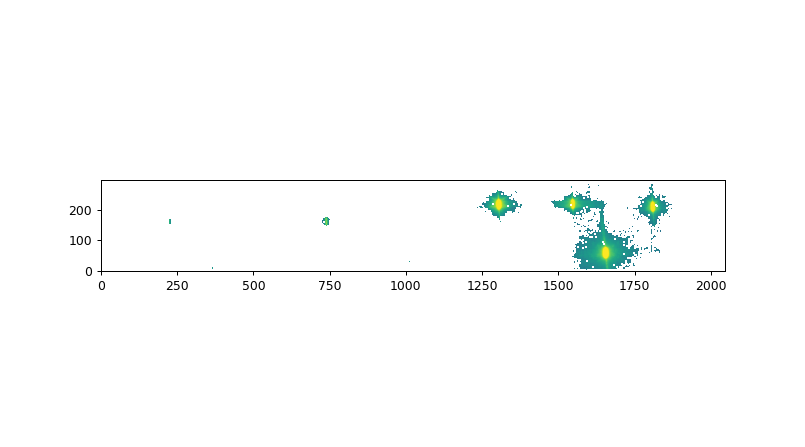

(300, 2048)


<ipython-input-4-be1a51166b44>:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image) , origin='lower')
<ipython-input-4-be1a51166b44>:11: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image) , origin='lower')


In [4]:
f_str = "high"
with gzip.open(f_str+".fits.gz") as f_unzipped:
    with fits.open(f_unzipped) as f_fits:
        f_fits.info()
        image = f_fits[0].data[:,:300]
        #image = np.flipud(np.fliplr(np.rot90(image)))
        #image = np.swapaxes(image,0,1)
        image = np.flip( np.transpose(f_fits[0].data[:,:300]) , axis=1 )
        plt.figure(figsize=(9,5))
        #plt.imshow(image , origin='lower')
        plt.imshow(np.log10(image) , origin='lower')

print(image.shape)

# Setup section

In [5]:
# monochromatic PSF trace order list
psf_orders = np.array([4,3,2,2,1,2,1,1])
# Wavelength in microns for each PSF trace
wavs = np.array([0.6412, 0.6412, 0.6412, 1.06262, 1.06262, 1.30838, 1.30838, 1.54676])
# Center point for each PSF trace
psf_centers = np.array([[9,363],[30,1008],[60,1635],[161,740],[210,1809],[161,225],[218,1549],[218,1303]])
# For each trace, identifies which file is most appropriate to extract tilt (avoids saturation)
psf_optimal_file = np.array(['high','high','low','high','low','high','low','low'])

# Extraction boxes for each PSF trace
# Have the form [ [min_spat,max_spat] , [min_spec,max_spec] ]
# If centered=True, then the spatial box size and location
#    is determined by the 'psf_centers' and by a user-defined spatial width
centered = True
spat_wid = 13
# 'keep' is a mask array that allows us to omit the tilt calculation for certain waves (i.e. orders 4 and 3)
keep = np.full(len(wavs),True); keep[1]=False; keep[0]=False
# Decide to save the calculatedd tilts or not
save = False

# Calculate the tilts

[ 3 16]
[24 37]
[54 67]
[155 168]
[204 217]
[155 168]
[212 225]
[212 225]


Order 2: Box #1


<IPython.core.display.Javascript object>


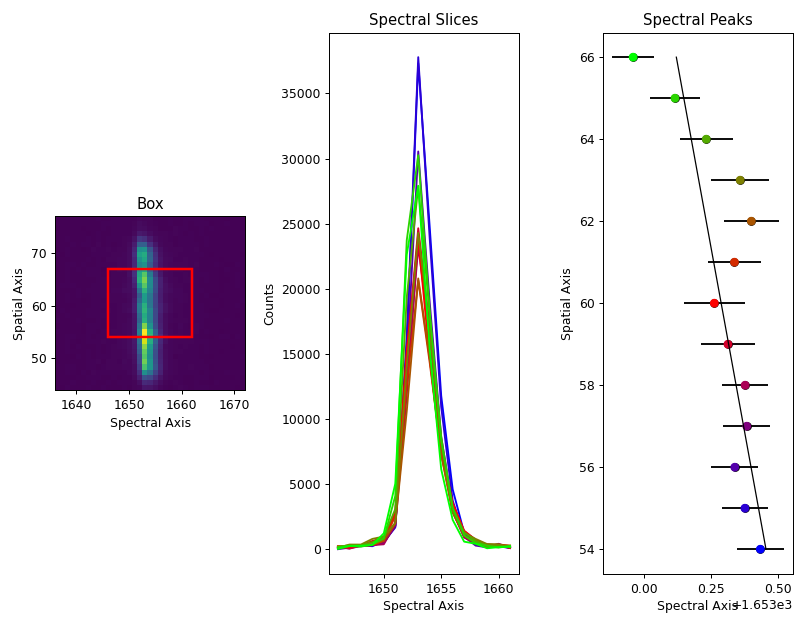

-1.6+/-0.4


Order 2: Box #2


<IPython.core.display.Javascript object>


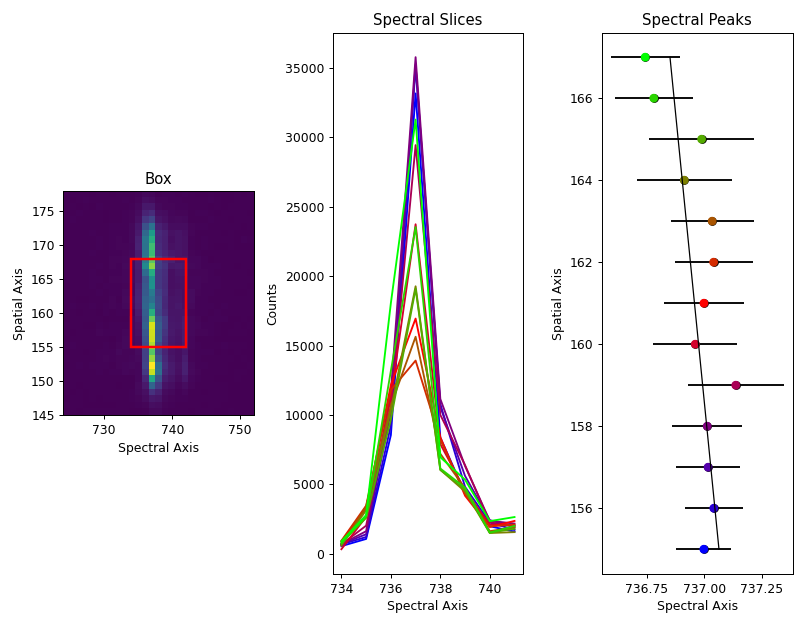

-1.02+/-0.31


Order 1: Box #1


<IPython.core.display.Javascript object>


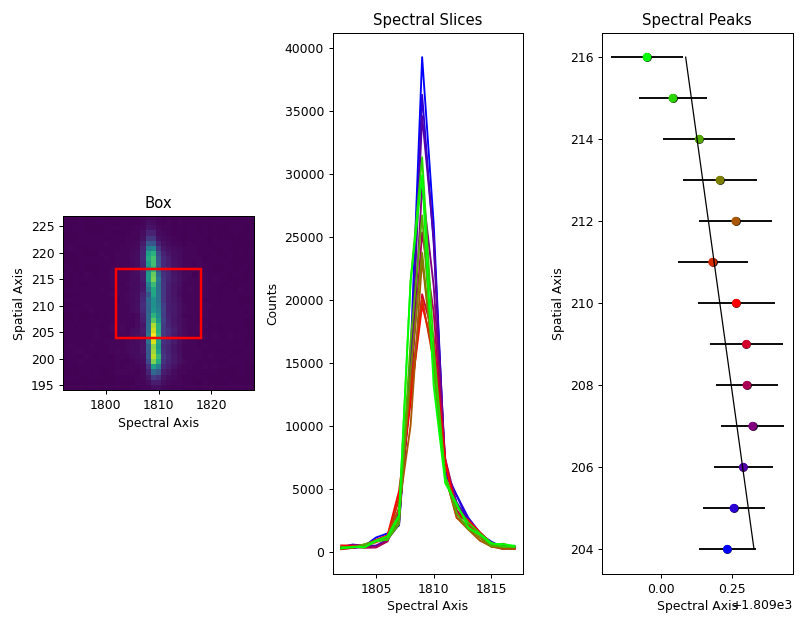

-1.14+/-0.30


Order 2: Box #3


<IPython.core.display.Javascript object>


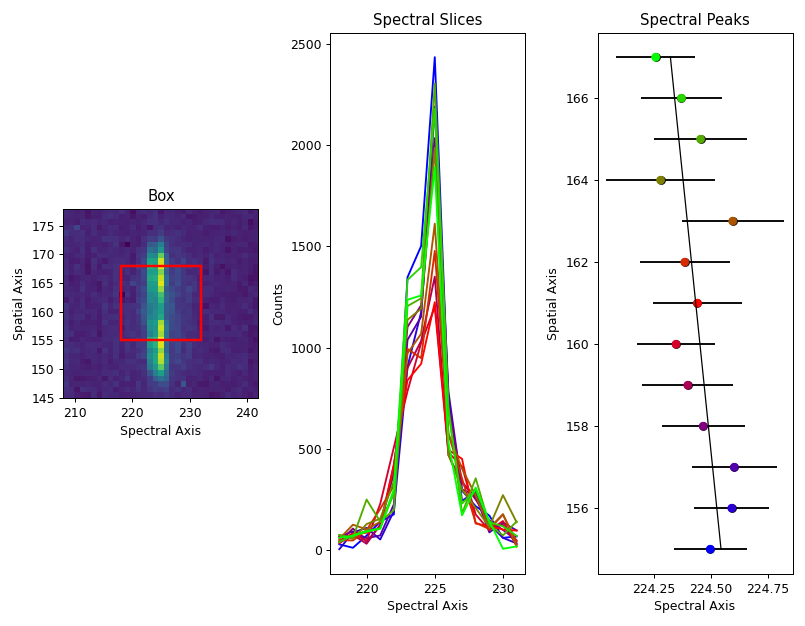

-1.06+/-0.35


Order 1: Box #2


<IPython.core.display.Javascript object>


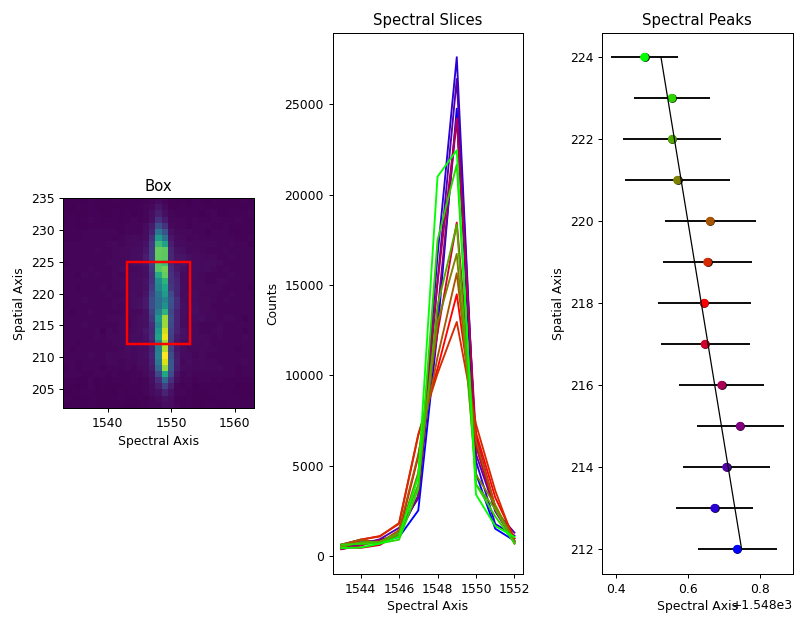

-1.07+/-0.15


Order 1: Box #3


<IPython.core.display.Javascript object>


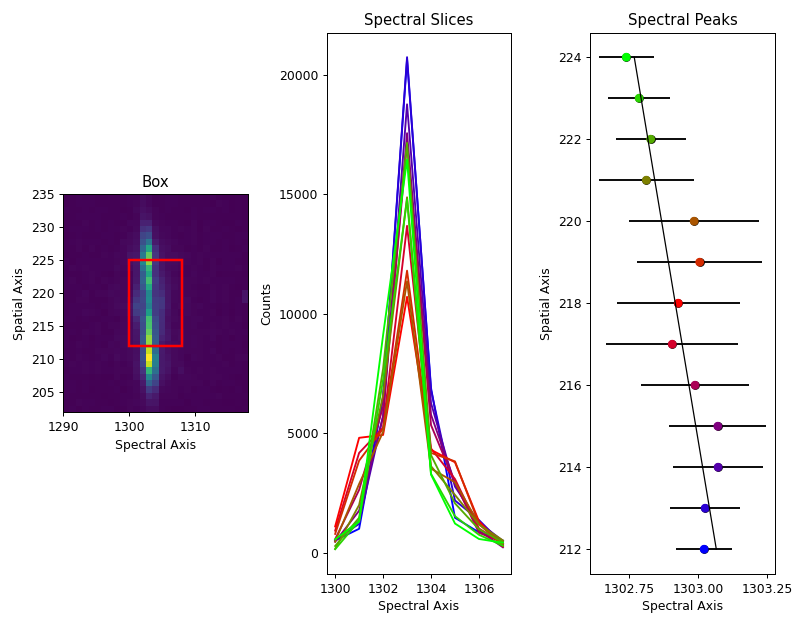

-1.42+/-0.17


<IPython.core.display.Javascript object>


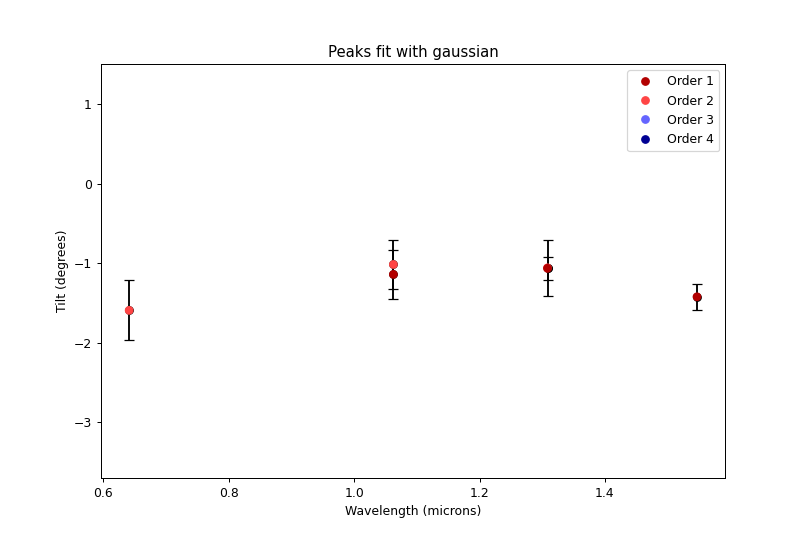

In [6]:
# Ignore the 'tight' things if centered=True
tight_all=False
tight_spat=False
even_tighter_spat=False
if tight_all:
    o4_b1 = [[6,13],[360,366]]
    o3_b1 = [[19,41],[1006,1012]]
    o2_b1 = [[49,71],[1648,1660]]
    o2_b2 = [[149,175],[736,740]]
    o1_b1 = [[199,222],[1804,1816]]
    o2_b3 = [[150,169],[220,230]]
    o1_b2 = [[208,227],[1545,1551]]
    o1_b3 = [[208,228],[1301,1307]]
elif tight_spat:
    o4_b1 = [[7,14],[358,368]]
    o3_b1 = [[18,41],[1004,1014]]
    o2_b1 = [[49,71],[1646,1662]]
    o2_b2 = [[149,175],[734,742]]
    o1_b1 = [[199,222],[1802,1818]]
    o2_b3 = [[150,169],[218,232]]
    o1_b2 = [[208,227],[1543,1553]]
    o1_b3 = [[208,228],[1300,1308]]
elif even_tighter_spat:
    o4_b1 = [[5,12],[358,368]]
    o3_b1 = [[21,39],[1004,1014]]
    o2_b1 = [[49,65],[1646,1662]]
    o2_b2 = [[151,166],[734,742]]
    o1_b1 = [[199,215],[1802,1818]]
    o2_b3 = [[150,169],[218,232]]
    o1_b2 = [[210,224],[1543,1553]]
    o1_b3 = [[212,224],[1300,1308]]
else:
    o4_b1 = [[4,15],[358,368]]
    o3_b1 = [[17,43],[1004,1014]]
    o2_b1 = [[47,73],[1646,1662]]
    o2_b2 = [[147,177],[734,742]]
    o1_b1 = [[197,224],[1802,1818]]
    o2_b3 = [[148,171],[218,232]]
    o1_b2 = [[206,229],[1543,1553]]
    o1_b3 = [[206,230],[1300,1308]]
boxes = np.array([o4_b1, o3_b1, o2_b1, o2_b2, o1_b1, o2_b3, o1_b2, o1_b3])

if centered and True:
    assert spat_wid % 2 == 1
    for i in range(len(boxes)):
        boxes[i][0] = [ int(floor_zero(psf_centers[i][0]-spat_wid//2)) , int(psf_centers[i][0]+spat_wid//2)+1 ]
        print(boxes[i][0])

# do it
if True:
    tilts_g = find_tilts( boxes[keep] , wavs[keep] , psf_orders[keep] , psf_optimal_file[keep]
                        , fit_func='gaussian'
                        , doPlot=(True,True) , keep=keep )
# do it again
if False:
    tilts_l = find_tilts( boxes[keep] , wavs[keep] , psf_orders[keep] , psf_optimal_file[keep]
                        , fit_func='lorentz'
                        , doPlot=(True,False) , keep=keep )

# AGAIN
if False:
    tilts_max = find_tilts( boxes[keep] , wavs[keep] , psf_orders[keep] , psf_optimal_file[keep]
                          , fit_func='maxval'
                          , doPlot=(False,False) , keep=keep )
    
if False:
    rez_tilts = np.array(tilts_g) - np.array(tilts_l)
    plt.figure(figsize=(8,5))
    plt.errorbar( np.arange(len(psf_orders[keep])) , [t.n for t in rez_tilts] , yerr=[t.s for t in rez_tilts] )
    plt.scatter( np.arange(len(psf_orders[keep])) , [t.n for t in rez_tilts] )
    plt.xticks( np.arange(len(psf_orders[keep])) , np.array(['o4_b1','o3_b1','o2_b1','o2_b2','o1_b1','o2_b3','o1_b2','o1_b3'])[keep] )
    plt.ylabel('Tilt (degree)')
    plt.title('Residuals of gauss vs lorentz fit')

    
# DO YOU WANT TO SAVE??
if save:
    # Save the gaussian-fit tilt
    save_g = np.zeros(( 4,len(wavs[keep]) ))
    save_g[0] = psf_orders[keep]
    save_g[1] = wavs[keep]
    save_g[2] = [t.n for t in tilts_g]
    save_g[3] = [t.s for t in tilts_g]
    np.savetxt("monoPSF_gauss_spat"+str(spat_wid)+".dat" , save_g , delimiter=' ')
    if False:
        # Save the gaussian-fit tilt (not as good as gaussians so not really useful I think)
        save_l = np.zeros(( 4,len(wavs) ))
        save_l[0] = psf_orders
        save_l[0] = wavs
        save_l[1] = [t.n for t in tilts_l]
        save_l[2] = [t.s for t in tilts_l]
        np.savetxt("monoPSF_lorentz.dat" , save_l , delimiter=' ')

# Some other (old) test stuff. Its just a mess.

In [ ]:
f_str = "low"

if f_str=="high":
    o1_b1 = [[194,226],[1795,1820]]
    o1_b2 = [[203,234],[1535,1557]]
    o1_b3 = [[200,234],[1290,1318]]

    o2_b1 = [[40,78],[1638,1670]]
    o2_b2 = [[147,177],[734,742]]
    o2_b3 = [[148,171],[218,232]]
    
    o3_b1 = [[17,43],[1004,1014]]
    
    o4_b1 = [[4,15],[358,368]]
    
elif f_str=="low":
    o1_b1 = [[197,224],[1805,1815]]
    o1_b1 = [[205,220],[1805,1815]]
    #o1_b1 = [[190,230],[1805,1815]]
    o1_b2 = [[206,232],[1545,1553]]
    o1_b2 = [[215,228],[1545,1553]]
    #o1_b2 = [[200,238],[1545,1553]]
    o1_b3 = [[206,230],[1300,1308]]
    o1_b3 = [[215,228],[1300,1308]]
    #o1_b3 = [[200,238],[1300,1308]]
    
    o2_b1 = [[47,73],[1650,1658]]
    o2_b1 = [[53,70],[1650,1658]]
    #o2_b1 = [[40,80],[1650,1658]]
    o2_b2 = [[150,173],[735,746]]
    o2_b2 = [[155,170],[735,746]]
    #o2_b2 = [[145,180],[735,746]]

boxes = [ o1_b1,o1_b2,o1_b3 , o2_b1,o2_b2 ]
indy = 4
offset = 0


with gzip.open(f_str+".fits.gz") as f_unzipped:
    with fits.open(f_unzipped) as f_fits:
        f_fits.info()
        image = np.flip( np.transpose(f_fits[0].data[:,:300]) , axis=1 )
        #plt.figure(figsize=(9,5))
        #plt.imshow(image , origin='lower')
        #plt.imshow(image[0:20 , 1610:1700] , origin='lower')#, norm=LogNorm())
        #plt.imshow(image[ boxes[indy][0][0]:boxes[indy][0][1] , boxes[indy][1][0]:boxes[indy][1][1] ] , origin='lower')

print(image.shape)


if False:
    indi = 4
    box = image[ boxes[indi][0][0]:boxes[indi][0][1] , boxes[indi][1][0]-offset:boxes[indi][1][1]+offset ]
    peaks = find_flux_peaks_in_box( box , spectral_offset=boxes[indi][1][0]-offset , init_error='poisson'
                                  , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func='lorentz'
                                  , fix_image=True)
    find_tilt_from_peaks(peaks)
    
    if False:
        
        peaks = find_flux_peaks_in_box( box , spectral_offset=boxes[indi][1][0]-offset , init_error='poisson-'
                                      , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func='lorentz'
                                      , fix_image=False)
        find_tilt_from_peaks(peaks)

        peaks = find_flux_peaks_in_box( box , spectral_offset=boxes[indi][1][0]-offset , init_error='poisson'
                                      , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func='lorentz'
                                      , fix_image=False)
        find_tilt_from_peaks(peaks)

        peaks = find_flux_peaks_in_box( box , spectral_offset=boxes[indi][1][0]-offset , init_error='poisson'
                                      , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func='lorentz'
                                      , fix_image=False)
        find_tilt_from_peaks(np.delete(peaks,20,axis=1))




if True:
    wavs = []
    box_count=1; reset=True
    for i,b in enumerate(boxes):
        if f_str!='low' or i != len(boxes)-1: 
            box = image[ b[0][0]:b[0][1] , b[1][0]-offset:b[1][1]+offset ]
            if i < 3: o_str='Order 1'
            else:
                o_str="Order 2"
                if reset:
                    box_count=1
                    reset=False

            print("\n\n"+o_str + ": Box #"+str(box_count))
            box_count += 1

            peaks = find_flux_peaks_in_box( box , spectral_offset=b[1][0]-offset , init_error='poisson'
                                          , init_guess=[] , bounds=(-np.inf,np.inf) , fit_func='gaussian'
                                          , fix_image=True)
            find_tilt_from_peaks(peaks)

# Calculate tilt with Loic's CCF method (unsuccessful)

Filename: low.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1024, 2048)   float32   


<IPython.core.display.Javascript object>


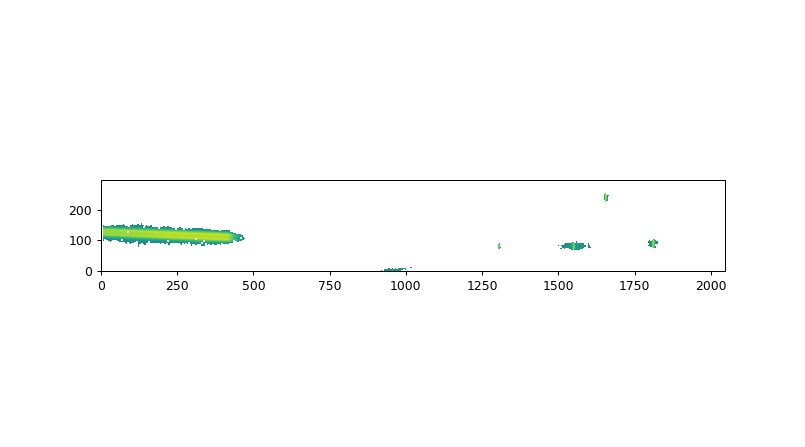

(300, 2048)


<ipython-input-21-99fb1fd4a3db>:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image) , origin='lower')
<ipython-input-21-99fb1fd4a3db>:9: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image) , origin='lower')


In [21]:
f_str = "low"
with gzip.open(f_str+".fits.gz") as f_unzipped:
    with fits.open(f_unzipped) as f_fits:
        f_fits.info()
        image = f_fits[0].data[:,:300]
        image = np.flipud(np.fliplr( np.transpose(f_fits[0].data[:,:300]) ) )
        plt.figure(figsize=(9,5))
        #plt.imshow(image , origin='lower')
        plt.imshow(np.log10(image) , origin='lower')

print(image.shape)

In [3]:
# monochromatic PSF trace order list
psf_orders = np.array([4,3,2,2,1,2,1,1])
# Wavelength in microns for each PSF trace
wavs = np.array([0.6412, 0.6412, 0.6412, 1.06262, 1.06262, 1.30838, 1.30838, 1.54676])
# Center point for each PSF trace
psf_centers = np.array([[9,363],[30,1008],[60,1635],[161,740],[210,1809],[161,225],[218,1549],[218,1303]])
spatial_height = 300
for i in range(len(psf_centers)):
    # Switch them over to the true DMS format (flip spatial axis)
    psf_centers[i][0] = spatial_height - psf_centers[i][0]
#print(psf_centers)
# For each trace, identifies which file is most appropriate to extract tilt (avoids saturation)
psf_optimal_file = np.array(['high','high','low','high','low','high','low','low'])

# 'keep' is a mask array that allows us to omit the tilt calculation for certain waves (i.e. orders 4 and 3)
keep = np.full(len(psf_orders),True); keep[[0,1,3,4,5]] = False
psf_orders = psf_orders[keep]; wavs = wavs[keep]; psf_centers = psf_centers[keep]
psf_optimal_file = psf_optimal_file[keep]

# Decide to save the calculatedd tilts or not
save = False

# Dimension of box around the trace

with gzip.open("low"+".fits.gz") as f_unzipped:
    with fits.open(f_unzipped) as f_fits:
        im_low = f_fits[0].data[:,:spatial_height]
        im_low = np.flipud(np.fliplr( np.transpose(im_low) ) ) # convert to DMS format from native view
with gzip.open("high"+".fits.gz") as f_unzipped:
    with fits.open(f_unzipped) as f_fits:
        im_high = f_fits[0].data[:,:spatial_height]
        im_high = np.flipud(np.fliplr( np.transpose(im_low) ) ) # convert to DMS format from native view


<IPython.core.display.Javascript object>


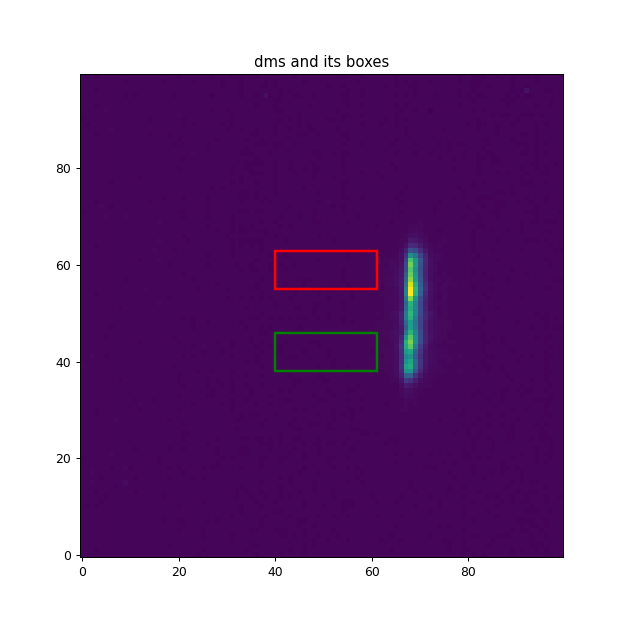

popt= [5.15283273e+05 4.66111300e+06 0.00000000e+00 1.00000000e+00]


/home/william/ongenesis/bin/miniconda3/envs/will_test/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


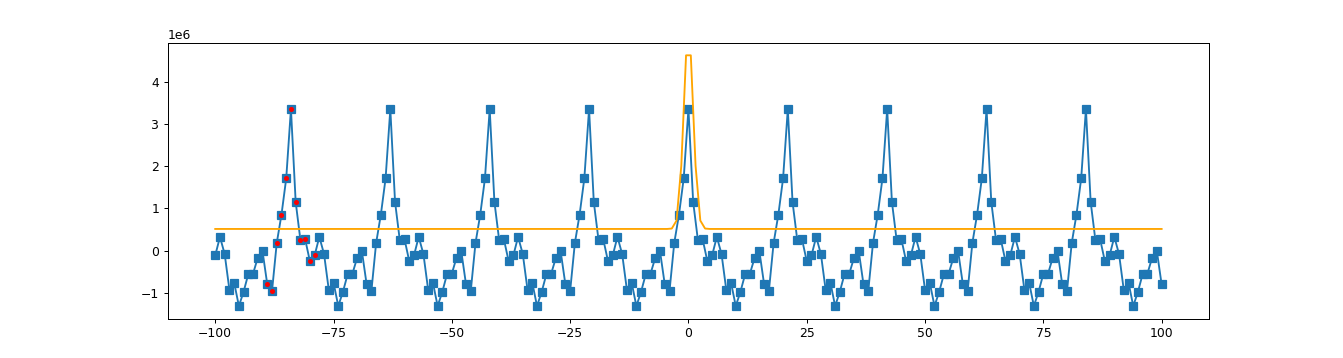

<IPython.core.display.Javascript object>


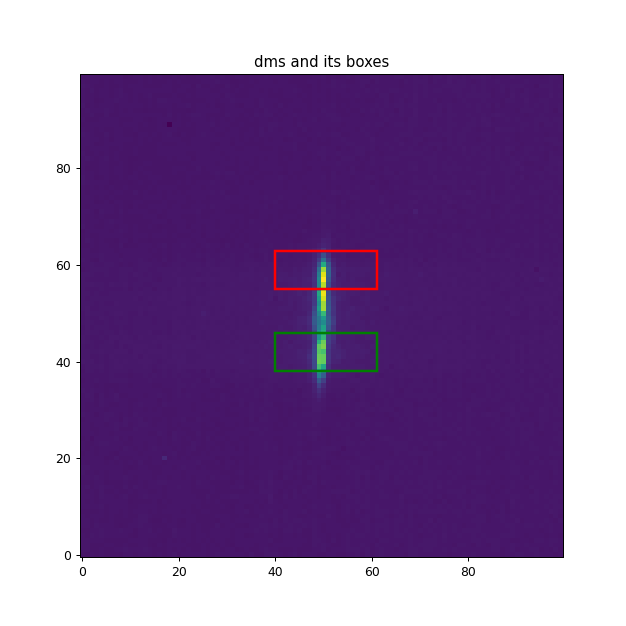

popt= [1.23470939e+10 3.49131080e+10 0.00000000e+00 1.00000000e+00]


/home/william/ongenesis/bin/miniconda3/envs/will_test/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


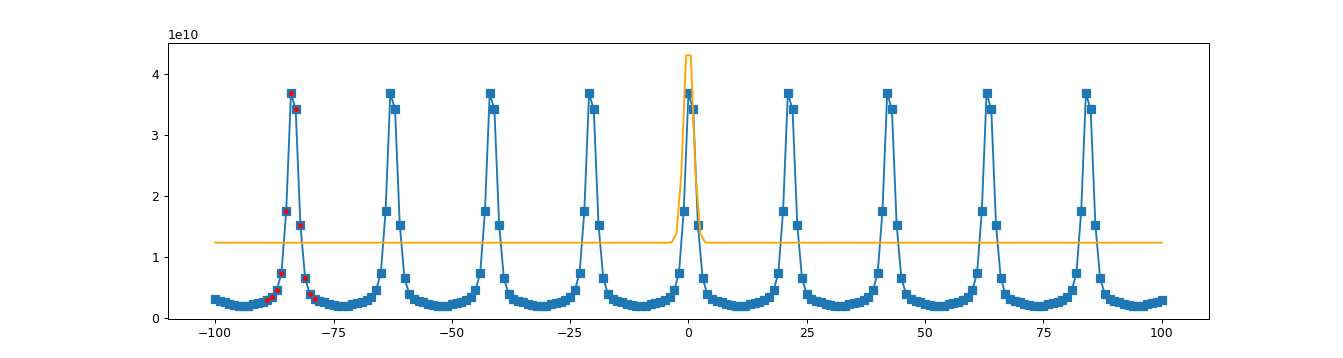

<IPython.core.display.Javascript object>


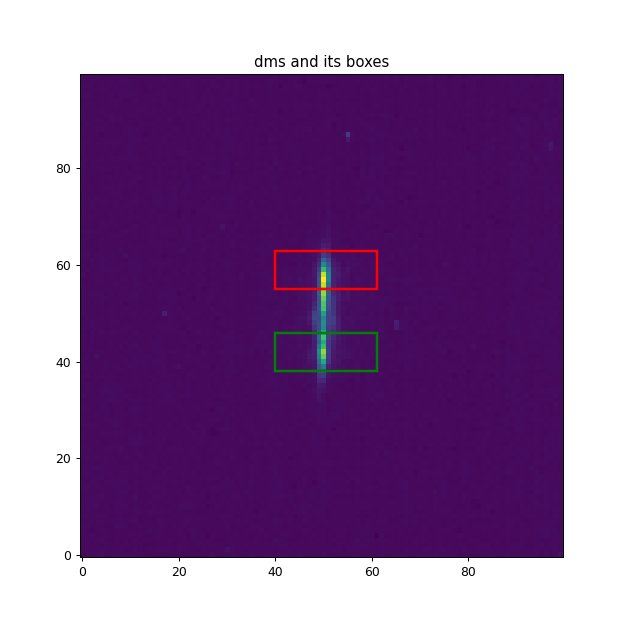

popt= [5.48650975e+09 1.87290205e+10 0.00000000e+00 1.00000000e+00]


/home/william/ongenesis/bin/miniconda3/envs/will_test/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


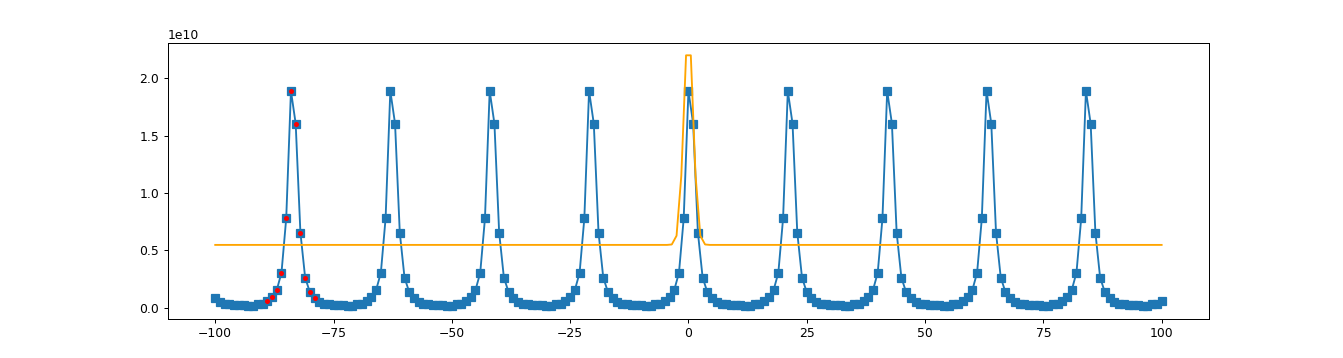

In [4]:
tilts = []
size = 50


for i in range(len(psf_orders)):
    
    if psf_optimal_file[i] == "high": im=im_high
    elif psf_optimal_file[i] == "low": im=im_low
    
    row_center = psf_centers[i][0]; col_center = psf_centers[i][1]
    
    psf = im[ row_center-size:row_center+size , col_center-size:col_center+size ]
    
    tilt = rot_wpsf.get_webbpsf_tilt( psf , oversamp=1 , view='dms' , fitrad=5
                                    , mode='ccf' , spatbox_size=23 , specbox_size=20
                                    , doPlot=True)
    tilts.append( tilt )

            

In [15]:
p = np.array([1.0,2.0,3.0])
if 1.0000 in p:
    print('yeah')
indy = np.where(p==2)[0][0]
print(indy)

yeah
1
